In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
from os.path import expanduser
from causets_py import causet_helpers as ch
from scipy.optimize import curve_fit
from scipy.stats import chisquare, pearsonr

rcParams = {}
font_size = 16
rcParams["text.usetex"] = True
rcParams["font.serif"] = "Helvetica"
rcParams["font.monospace"] = "Helvetica Mono"
rcParams["font.size"] = font_size
rcParams["axes.labelsize"] = font_size + 5
rcParams["axes.labelweight"] = "bold"
rcParams["axes.titlesize"] = font_size
rcParams["xtick.labelsize"] = font_size
rcParams["ytick.labelsize"] = font_size
rcParams["legend.fontsize"] = font_size
rcParams["figure.titlesize"] = font_size

ticks_size = 2
rcParams["xtick.direction"] = "in"
rcParams["xtick.minor.visible"] = True
rcParams["xtick.top"] = True   # draw ticks on the top side
rcParams["ytick.direction"] = "in"
rcParams["ytick.minor.visible"] = True
rcParams["ytick.right"] = True   # draw ticks on the top side
rcParams["xtick.major.size"] = 2*ticks_size
rcParams["xtick.minor.size"] = ticks_size
rcParams["ytick.major.size"] = 2*ticks_size
rcParams["ytick.minor.size"] = ticks_size
ticks_width_value = 1
rcParams["axes.linewidth"] = ticks_width_value
rcParams["xtick.major.width"] = ticks_width_value
rcParams["xtick.minor.width"] = ticks_width_value
rcParams["ytick.major.width"] = ticks_width_value
rcParams["ytick.minor.width"] = ticks_width_value

rcParams["legend.borderpad"] = 0.5
rcParams["legend.frameon"] = False
rcParams["legend.handletextpad"] = 0.3
rcParams["legend.handlelength"] = 1.7
rcParams["lines.linewidth"] = 2
plt.rcParams.update(rcParams)
del rcParams

# params = {'text.usetex' : True,
#           'font.size' : 25,
#           'font.family' : 'Times New Roman',
#           'axes.labelsize': 28,
#           'legend.fontsize': 20,
#           'xtick.labelsize': 22,
#           'ytick.labelsize': 22,
#           'figure.figsize': [8.5, 6.5], 
#           }
# #plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
# plt.rcParams.update(params)
# del params

# User Input

In [2]:
# 0. SET USER VARIABLES
##############################################################################
molecules = "lambdas" #lambdas, HRVs
varying_var = "M"     #variable varying: can be M, Rho, Nmult (M best)
fixed_var = "Rho"     #variable fixed:   can be, M, Rho, Nmult (Rho best)
fixed_val = 5000     #value of fixed_var 
use_selected_masses = True #gives equal spacing

#stef_txt_in_file = 1 #used when _stef.txt was added from Stef's jobs

plot_histogram_Nreps = 1
plot_boundaries = 1
plot_molecules = 1
do_also_not_main_plots = 0 #those NOT for poster nor thesis

In [3]:
# 1 SET USEFUL STRINGS & OTHER VARIABLES
##############################################################################
home = expanduser("~")
plotsDir = f"{home}/MSci_Schwarzschild_Causets/figures/N{molecules}_vs_Area/"
dataDir = f"{home}/MSci_Schwarzschild_Causets/data/{molecules}/"
#dataDir = home + f"/MSci_Schwarzschild_Causets/data/linkcounting_files/Poiss=False/"
if not os.path.exists(dataDir):
    path = os.getcwd()
    if "\scripts_py" in path:
        path = path.replace("\scripts_py", "")
    plotsDir = path + f"/figures/N{molecules}_vs_Area/"
    dataDir = path + f"/data/{molecules}/"
print(dataDir)
# ensure that, if using Mor Rho, it is decimal with exactly 2 dec digits

if fixed_var == "M" or fixed_var == "Rho":
    fixed_string = f"{fixed_var}=" + format(fixed_val,".2f")
else:
    fixed_string = f"{fixed_var}={fixed_val}"


selected_masses = np.array([
                            0.53 ,0.65, 0.75, 0.84, 0.92, 0.99, 1.06, 
                            1.13, 1.19, 1.24, 1.30, 1.35, 1.40, 1.45,
                            1.50, 1.55, 1.59, 1.63, 1.68, 1.72, 1.76, 
                            1.80, 1.84, 1.88, 1.91, 1.95, 1.98, 2.02, 
                            2.05, 2.09, 2.12, 2.15, 2.19, 2.22, 2.25, 
                            2.28, 2.31, 2.34, 2.37, 2.40, 
                            2.43, 2.46, 2.49, 2.52, 2.54, 2.57, 2.60, 2.63,
                            2.65, 2.68, 2.7, 2.73, 2.76, 2.78, 2.81, 2.83,
                            2.86, 2.88, 2.91, 2.93, 2.95, 2.98, 3.0,
                            3.02, 3.05, 3.07, 3.09,
                            3.12, 3.14, 3.16, 3.18, 3.20, 3.23,
                            3.25, 3.27, 3.29, 3.31, 3.3337, 3.3547,
                            3.3756, 3.3964, 3.417, 3.4375,
                            ])
selected_masses = [round(m, 2) for m in selected_masses]

c:\Users\Stefano\OneDrive - Imperial College London\University\year4 stuff\1.Causets Project\VidGitCode\MSci_Schwarzschild_Causets/data/lambdas/


# Get Files Info

In [5]:
# 2. GET INFO FROM FILES
##############################################################################

# an entry for each M
Nreps = []
varying_values = []
outermosts = []
outermosts_std = []
innermosts = []
innermosts_std = []
mintimes = []
mintimes_std = []
# matrix: a row for each type of molecule 
#           -> molecules_distr[i] = array of occurrences of ith mol for each rho
#         a column for each rho
molecules_distr = []    # each ith entry is an array whose jth entry is
                        # the # of times the ith lambdas found for mass j
molecules_distr_std = [] #same, but std


for root, dirs, files in os.walk(dataDir):
    # for each file file_i
    for i, file_i in enumerate(files):
        if fixed_string in file_i:
            go_on = False
            if varying_var+"=" in file_i:
                go_on = True
                file_i_path = os.path.join(root, file_i)
                file_i_pieces = file_i.split("_")
                # get the value of the varying variable of file_i
                for piece_j in file_i_pieces:
                    if varying_var+"=" in piece_j:
                        varying_var_i = float(piece_j.split("=")[1])
                        if use_selected_masses \
                            and varying_var_i not in selected_masses:
                            go_on = False
                            break #j loop
                        if varying_var_i not in varying_values:
                            print(varying_var+"=", varying_var_i)
                            varying_values.append(varying_var_i)
                        break
            # if the file is correct
            if go_on: 
                # 2.1 get file and Nreps #####################################
                try:
                    everything_i = np.loadtxt(file_i_path, 
                                            delimiter = ",", skiprows=1,
                                            dtype = str)[:,:-1].astype(float)
                except IndexError: # only one line of data in txt file
                    everything_i = np.loadtxt(file_i_path, 
                                            delimiter = ",", skiprows=1,
                                            dtype = str)[:-1].astype(float)
                    everything_i=np.array([everything_i]) #make it 2D for latr
                Nreps_i = everything_i[:,0]
                tot_Nreps_i = sum(Nreps_i)
                Nreps.append(tot_Nreps_i)
                # 2.2 get mintime, innermost, outermost ####################
                outermosts_avg_arr_i = everything_i[:,1]
                outermosts_std_arr_i = everything_i[:,2]
                innermosts_avg_arr_i = everything_i[:,3]
                innermosts_std_arr_i = everything_i[:,4]
                mintimes_avg_arr_i   = everything_i[:,5]
                mintimes_std_arr_i   = everything_i[:,6]
                outermost_i, outermost_std_i = ch.combine_meass(Nreps_i,
                                                        outermosts_avg_arr_i,
                                                        outermosts_std_arr_i,)
                innermost_i, innermost_std_i = ch.combine_meass(Nreps_i,
                                                        innermosts_avg_arr_i,
                                                        innermosts_std_arr_i,)
                mintime_i, mintime_std_i = ch.combine_meass(Nreps_i,
                                                        mintimes_avg_arr_i,
                                                        mintimes_std_arr_i,)
                outermosts    .append(outermost_i)
                outermosts_std.append(outermost_std_i)
                innermosts    .append(innermost_i)
                innermosts_std.append(innermost_std_i)
                mintimes      .append(mintime_i)
                mintimes_std  .append(mintime_std_i)
                # 2.3 get molecules info #####################################
                mol_info_i = everything_i[:,7:]
                ntypes_i = mol_info_i.shape[1]/2
                # should be even
                if (ntypes_i - int(ntypes_i)): 
                    raise Exception(f"Number of cols {ntypes_i*2} is odd")
                else:
                    ntypes_i = int(ntypes_i)
                #molecules_distr.append([])
                #molecules_distr_std.append([])
                for n in range(ntypes_i):
                    avgs_mol_n_i = mol_info_i[:,2*n]
                    stds_mol_n_i = mol_info_i[:,2*n+1]
                    n_mol_n_i, std_mol_n_i = ch.combine_meass(Nreps_i,
                                                            avgs_mol_n_i,
                                                            stds_mol_n_i)
                    # if the nth molecule had already been found
                    try:
                        molecules_distr[n]    .append(n_mol_n_i)
                        molecules_distr_std[n].append(std_mol_n_i)
                    #if the nth molecule was never found
                    except IndexError: 
                        # make zeros for previous (general for rho and nmult)
                        n_prev_values = len(varying_values) -1
                        zeros = np.zeros(n_prev_values).tolist()
                        molecules_distr    .append(zeros + [n_mol_n_i]) 
                        molecules_distr_std.append(zeros + [std_mol_n_i])


n_max = max([len(l) for l in molecules_distr])
for l,ls in zip(molecules_distr, molecules_distr_std):
    while len(l) < n_max:
        l.append(0)
        ls.append(0)

M= 0.53
M= 0.65
M= 0.75
M= 0.84
M= 0.92
M= 0.99
M= 1.06
M= 1.13
M= 1.19
M= 1.24
M= 1.3
M= 1.35
M= 1.4
M= 1.45
M= 1.5
M= 1.55
M= 1.59
M= 1.63
M= 1.68
M= 1.72
M= 1.76
M= 1.8
M= 1.84
M= 1.88
M= 1.91
M= 1.95
M= 1.98
M= 2.02
M= 2.05
M= 2.09
M= 2.12
M= 2.15
M= 2.19
M= 2.22
M= 2.25
M= 2.28
M= 2.31
M= 2.34
M= 2.37
M= 2.4
M= 2.43
M= 2.46
M= 2.49
M= 2.52
M= 2.54
M= 2.57
M= 2.6
M= 2.63
M= 2.65
M= 2.68
M= 2.7
M= 2.73
M= 2.76
M= 2.78
M= 2.81
M= 2.83
M= 2.86
M= 2.88
M= 2.91
M= 2.93
M= 2.95
M= 2.98
M= 3.0
M= 3.02
M= 3.05
M= 3.07
M= 3.09
M= 3.12
M= 3.14
M= 3.16
M= 3.18
M= 3.2
M= 3.23
M= 3.25
M= 3.27
M= 3.29
M= 3.31
M= 3.33
M= 3.35
M= 3.38
M= 3.4
M= 3.42
M= 3.44


# Fit & Plot

In [6]:
# 3.0 Useful Function and Definitions
# Fitting function == linear through vertex
def lin_func(x,a):
    " x is Area in l units"
    return a*x

# Fitting function2 == corrected-linear through vertex
def corrected_lin_func(x,a, coeff = - 0.0557704):
    " x is A in l units, returns (a + coeff/sqrtA)*x"
    sqrtA = np.sqrt(x)
    return (a + coeff/sqrtA)*x

def i_exp(n, I):
    """ (1-I) * I^(n-1) """
    return (1. - I) * I**(n-1)

def chi_exp(n, chi):
    """ I = e^{-chi} -> (1-I) * I^(n-1) """
    return (1. - np.exp(-chi)) * np.exp(-chi)**(n-1)

def i_exp_on_n(n, I):
    """ - [ I / ln(1-I) ] * I^(n-1) """
    A = - I / np.log(1-I)
    return A * I**(n-1) /n

# Set the right x for the varying-fixed values -> Area in l^2 units
x = np.array(varying_values)
if varying_var=="M":
    x = 4*np.pi*(2*x)**2 #==Area
    if fixed_var == "Nmult":    
        Rho = fixed_val/(4/3*np.pi*26)
        print(f"You're doing Nmult {fixed_val} fixed!") 
    elif fixed_var == "Rho":
        Rho = fixed_val
    x /= Rho**(-1/2)
r_S_norm = np.sqrt(x / 4 / np.pi)   
    # x_A = x/divide by fund units

print(f"Rho = {Rho:.0f}")
fixed_string = rf"Rho = {Rho:.0f}"

Rho = 5000


## Nreps Histogram

In [7]:
# 3.1 Nreps ##############################################
if plot_histogram_Nreps:
    varying_values_copy = np.array(varying_values)
    combined = list(zip(varying_values_copy, Nreps)) 
    sorted_combined = sorted(combined, key=lambda x: x[0]) # sort by values
    vals = [x[0] for x in sorted_combined] 
    Nreps = [x[1] for x in sorted_combined]
    print(vals)
    print(Nreps)
    # plt.figure("Histogram Nreps", (20, 6))
    # plt.plot(vals, Nreps, "x", markersize = 5, ls ="")
    # plt.xticks(vals, fontsize = 5)
    # plt.vlines(vals, 0, 200, alpha = 0.1, ls ="--")
    # plt.ylabel("Nreps")
    # plt.xlabel("M")
    # plt.tight_layout()
    # plt.savefig(plotsDir + f"{fixed_string}_{molecules}Nreps.png")
    # plt.show()

    vals_not_200 = [vals [i] for i in range(len(vals)) if Nreps[i] != 200]
    reps_not_200 = [Nreps[i] for i in range(len(vals)) if Nreps[i] != 200]
    repstable = pd.DataFrame(
                  np.column_stack(
                    [vals_not_200, reps_not_200, 200-np.array(reps_not_200)]),
                  columns = ["M Value", "Current Nreps", "Reps to 200"])
    print(repstable)

[0.53, 0.65, 0.75, 0.84, 0.92, 0.99, 1.06, 1.13, 1.19, 1.24, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.59, 1.63, 1.68, 1.72, 1.76, 1.8, 1.84, 1.88, 1.91, 1.95, 1.98, 2.02, 2.05, 2.09, 2.12, 2.15, 2.19, 2.22, 2.25, 2.28, 2.31, 2.34, 2.37, 2.4, 2.43, 2.46, 2.49, 2.52, 2.54, 2.57, 2.6, 2.63, 2.65, 2.68, 2.7, 2.73, 2.76, 2.78, 2.81, 2.83, 2.86, 2.88, 2.91, 2.93, 2.95, 2.98, 3.0, 3.02, 3.05, 3.07, 3.09, 3.12, 3.14, 3.16, 3.18, 3.2, 3.23, 3.25, 3.27, 3.29, 3.31, 3.33, 3.35, 3.38, 3.4, 3.42, 3.44]
[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 160.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0,

## Molecules Boundaries

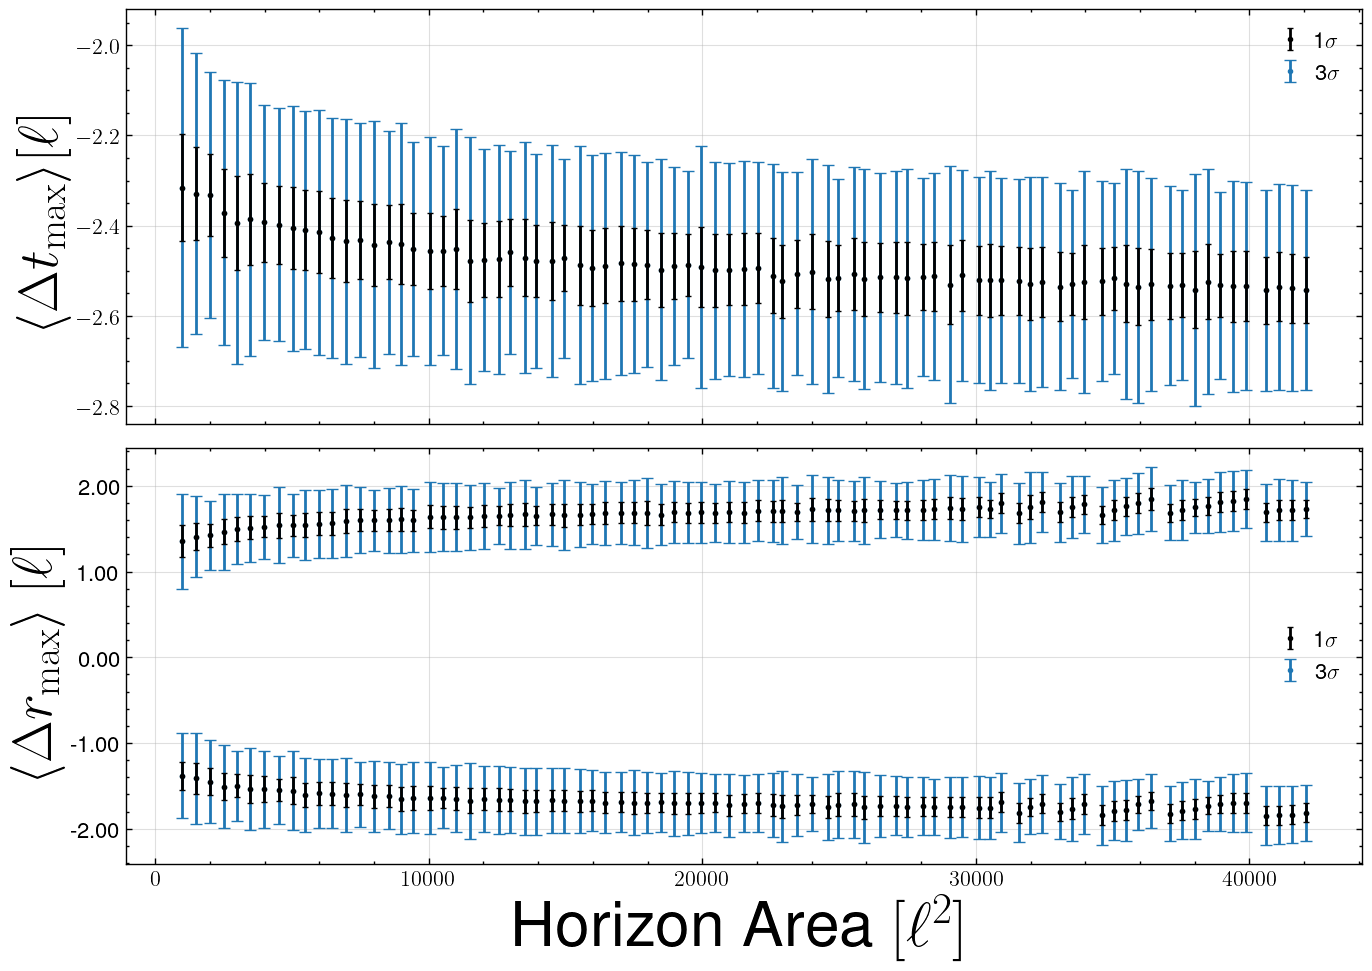

In [11]:
# 3.2 MOLECULES'S BOUNDARIES 
if plot_boundaries:
    try:
        if not run:
            mintimes       = np.array(mintimes)      * Rho**(1/4)
            mintimes_std   = np.array(mintimes_std)  * Rho**(1/4)
            innermosts     = np.array(innermosts)    * Rho**(1/4)
            innermosts_std = np.array(innermosts_std)* Rho**(1/4)
            outermosts     = np.array(outermosts)    * Rho**(1/4)
            outermosts_std = np.array(outermosts_std)* Rho**(1/4)
            run = True
    except NameError:
        mintimes       = np.array(mintimes)      * Rho**(1/4)
        mintimes_std   = np.array(mintimes_std)  * Rho**(1/4)
        innermosts     = np.array(innermosts)    * Rho**(1/4)
        innermosts_std = np.array(innermosts_std)* Rho**(1/4)
        outermosts     = np.array(outermosts)    * Rho**(1/4)
        outermosts_std = np.array(outermosts_std)* Rho**(1/4)
        run = True
        
    rc = 2; c = 1; r = 2
    plt.figure(f'Boundaries for {fixed_string}', figsize = (14,10),
                tight_layout = True)

    # MINTIME #######################################################
    ax = plt.subplot(r, c, 1)
    #plt.annotate ("a)", (-0.2, 1.05), xycoords = "axes fraction", 
    #               va='bottom', ha = 'left')
    plt.errorbar(x, mintimes, mintimes_std, 
                fmt = '.', capsize = 2, color = "black",
                zorder = 10, label = r"1$\sigma$")
    plt.errorbar(x, mintimes, 3*np.array(mintimes_std), 
                fmt = '.', capsize = 4, color = "C0",
                zorder = 5, label = r"3$\sigma$")
    ax.set_xticklabels([])
    plt.ylabel(r'$\langle \Delta t_{\mathrm{max}} \rangle [\ell]$', fontsize=40)
    plt.legend()
    plt.grid(alpha = 0.4) 

    # INNERMOST & OUTMOST ####################################################
    ax = plt.subplot(r, c, 2)
    #plt.annotate ("b)", (-0.2, 1.05), xycoords = "axes fraction", 
    #               va='bottom', ha = 'left')
    plt.errorbar(x, innermosts-r_S_norm, innermosts_std, 
                fmt = '.', capsize = 2, color = "black",
                zorder = 10, label = r"1$\sigma$")
    plt.errorbar(x, innermosts-r_S_norm, 3*innermosts_std, 
                fmt = '.', capsize = 4, color = "C0",
                zorder = 5, label = r"3$\sigma$")
    plt.errorbar(x, outermosts-r_S_norm, outermosts_std, 
                fmt = '.', capsize = 2, color = "black",
                zorder = 10)#, label = r"Outermost (with 1$\sigma$)")
    plt.errorbar(x, outermosts-r_S_norm, 3*outermosts_std, 
                fmt = '.', capsize = 4, color = "C0",
                zorder = 5)#, label = r"Outermost (with 5$\sigma$)")

    if varying_var == "M":
        plt.xlabel(r'Horizon Area $[\ell^2]$', fontsize=45)
    else:
        plt.xlabel(f'{varying_var} [a.u.]', fontsize=45)
    plt.ylabel(r"$\langle \Delta r_{\mathrm{max}} \rangle$ $[\ell]$",  fontsize=40)
    plt.grid(alpha = 0.4) 
    from matplotlib.ticker import FormatStrFormatter
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.legend()
    plt.tight_layout()
    plt.savefig(plotsDir + f"{fixed_string}_{molecules}Boundaries_to_rs_in_l.png")
    plt.savefig(plotsDir + f"{fixed_string}_{molecules}Boundaries_to_rs_in_l.pdf")
    plt.show()

## Molecules Number


Gradient factor for 1-lambda = 0.10784 +- 0.00022
Linearity of 1-lambda data:Pearson r = 1.0, p-value = 1.0
Gradient factor for 2-lambda = 0.02303 +- 0.00011
Linearity of 2-lambda data:Pearson r = 1.0, p-value = 1.0
Gradient factor for 3-lambda = 0.00521 +- 5e-05
Linearity of 3-lambda data:Pearson r = 1.0, p-value = 1.0
Gradient factor for 4-lambda = 0.00115 +- 3e-05
Linearity of 4-lambda data:Pearson r = 1.0, p-value = 1.0
Gradient factor for 5-lambda = 0.00024 +- 1e-05
Linearity of 5-lambda data:Pearson r = 0.998, p-value = 1.0
Gradient factor for 6-lambda = 5e-05 +- 1e-05
Linearity of 6-lambda data:Pearson r = 0.99, p-value = 1.0
Gradient factor for 7-lambda = 1e-05 +- 0.0
Linearity of 7-lambda data:Pearson r = 0.948, p-value = 1.0
Gradient factor for 8-lambda = 0.0 +- 0.0
Linearity of 8-lambda data:Pearson r = 0.587, p-value = 1.0
Gradient factor for 9-lambda = 0.0 +- 0.0
Linearity of 9-lambda data:Pearson r = -0.277, p-value = 0.989
Gradient factor for 10-lambda = 0.0 +- 0.0
Line

c:\Users\Stefano\anaconda3\envs\myenv\lib\site-packages\scipy\optimize\minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma


c:\Users\Stefano\OneDrive - Imperial College London\University\year4 stuff\1.Causets Project\VidGitCode\MSci_Schwarzschild_Causets/figures/Nlambdas_vs_Area/Rho = 5000_lambdas.png
c:\Users\Stefano\OneDrive - Imperial College London\University\year4 stuff\1.Causets Project\VidGitCode\MSci_Schwarzschild_Causets/figures/Nlambdas_vs_Area/Rho = 5000_lambdas.pdf


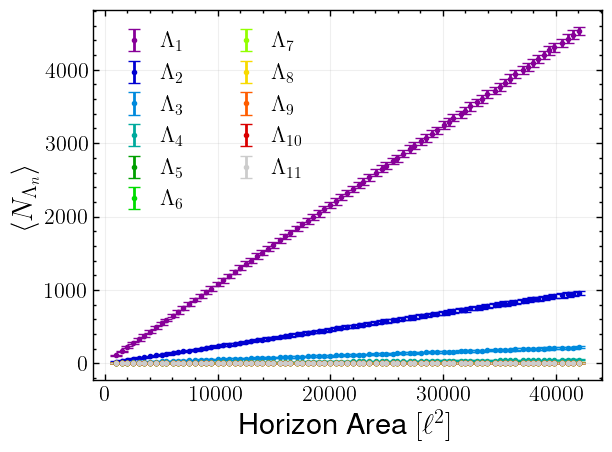

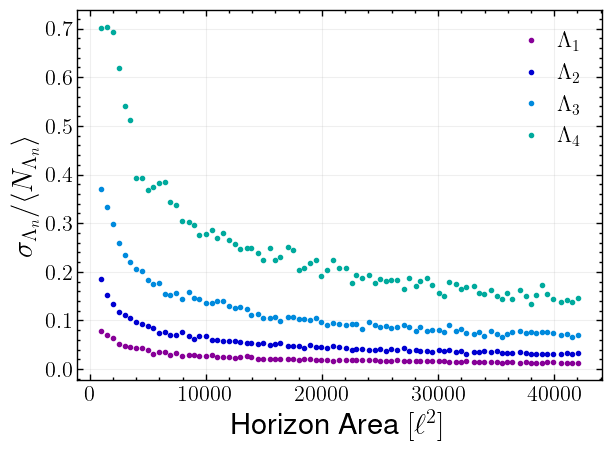

In [12]:
# 3.3 MOLECULES'S DISTRIBUTION 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = [plt.get_cmap("nipy_spectral")(v)
                                                for v in np.linspace(0.1,1, 11)])
print("")
if plot_molecules:

    plt.figure(f"Molecules for {fixed_string}")

    gradients     = [] # list of gradients of linear fit
    gradients_unc = [] # uncertainties of linear fit
    unsafe_start  = len(molecules_distr)
                       # first lambda that returns exception in curve_fit,
                       # implying not enough statistics is there
    for n in range(len(molecules_distr)):
        y    = molecules_distr[n]
        yerr = molecules_distr_std[n]
        label = ("Open HRV" if n==0 else "Closed HRV ") if molecules == "HRVs"\
                else r"$\Lambda_{" + str(n+1) + r"}$"
        plt.errorbar(x, y, yerr, 
                    fmt = '.', capsize = 4, 
                    label = label)

        # print(f"mean of # of {n+1}-Lambda: {[round(yi,8) for yi in y]}")
        # print(f"stds of # of {n+1}-Lambda: {[round(yerri,8) for yerri in yerr]}")
        # n-Lambda Linear fit to line through vertex
        Chi2, pvalue = None, None
        try:
            popt, pcov = curve_fit(lin_func, x, y, sigma=yerr,
                                    absolute_sigma=True)
            unc = np.sqrt(np.diag(pcov))
            if (unsafe_start == len(molecules_distr) and np.isnan(unc[0])):
                unsafe_start = n 
            expected = lin_func(x, *popt)
            #Chi2, pvalue = chisquare(y, expected, len(popt)) #not ideal
        except RuntimeError:
            if (unsafe_start == len(molecules_distr)):
                unsafe_start = n 
            non0_indices = tuple([np.where(np.array(y) != 0)])
            xs2      = np.array(x)[non0_indices][0]
            ys2      = np.array(y)[non0_indices][0]
            yerrs2   = np.array(yerr)[non0_indices][0]
            popt, pcov = curve_fit(lin_func, xs2, ys2, sigma=yerrs2,
                                    absolute_sigma=True)
            unc = np.sqrt(np.diag(pcov))
        print(f"Gradient factor for {n+1}-lambda"+
                f" = {round(popt[0],5)} +- {round(unc[0],5)}")
        r, pvalue = pearsonr(x, y)
        print(f"Linearity of {n+1}-lambda data:"+ 
                f"Pearson r = {round(r,3)}, p-value = {round(1-pvalue,3)}")
        #print(f"The associated Chi2 = {Chi2} and p-value = {pvalue}")
        
        
        xfit = np.linspace(min(x),max(x),100)
        #plt.plot(xfit, lin_func(xfit,*popt), '--', color="red")
        gradients.append(popt[0])
        gradients_unc.append(unc[0])
    
    props = dict(boxstyle='round', facecolor='white', edgecolor = 'black', 
                ls = '-', alpha=1)
    #plt.annotate(rf"$\rho \: = \: {Rho:.0f}$", (0.95, 0.5), xycoords = "axes fraction",
    #        fontsize=12, va='center', ha = 'right', bbox=props)
    plt.legend(ncol = 2)
    plt.xlabel(r'Horizon Area $[\ell^2]$')
    plt.ylabel(r"$ \langle N_{\Lambda_n} \rangle $")
    plt.grid(alpha = 0.2)
    plt.tight_layout()
    print(plotsDir + f"{fixed_string}_{molecules}.png")
    plt.savefig(plotsDir + f"{fixed_string}_{molecules}.png") 
    print(plotsDir + f"{fixed_string}_{molecules}.pdf")
    plt.savefig(plotsDir + f"{fixed_string}_{molecules}.pdf") 
    plt.show()

    if do_also_not_main_plots:
        plt.figure(f"Medium molecules for {fixed_string}")
        for n in range(3, min(6, len(molecules_distr))):
            y    = molecules_distr[n]
            yerr = molecules_distr_std[n]
            label = ("Open HRV" if n==0 else "Closed HRV ") if molecules == "HRVs" \
                    else r"$\Lambda_{" + str(n+1) + r"}$"
            plt.errorbar(x, y, yerr, 
                        fmt = '.', capsize = 4, 
                        label = label)
        plt.legend()
        plt.xlabel(r'Horizon Area $[\ell^2]$') #not yet in terms of l^2
        plt.ylabel(r"Number of $\Lambda_{n}$")
        plt.grid(alpha = 0.2)
        plt.tight_layout()
        plt.savefig(plotsDir + f"{fixed_string}_large_{molecules}.png")
        plt.savefig(plotsDir + f"{fixed_string}_large_{molecules}.pdf") 
        plt.show()


        plt.figure(f"Large molecules for {fixed_string}")
        for n in range(min(6, len(molecules_distr)), len(molecules_distr)):
            y    = molecules_distr[n]
            yerr = molecules_distr_std[n]
            label = ("Open HRV" if n==0 else "Closed HRV ") if molecules == "HRVs" \
                    else r"$\Lambda_{" + str(n+1) + r"}$"
            plt.errorbar(x, y, yerr, 
                        fmt = '.', capsize = 4, 
                        label = label)
        plt.legend()
        plt.xlabel(r'Horizon Area $[\ell^2]$') #not yet in terms of l^2
        plt.ylabel(r"$ \langle N_{\Lambda_n} \rangle $")
        plt.grid(alpha = 0.2)
        plt.tight_layout()
        plt.savefig(plotsDir + f"{fixed_string}_XXL_{molecules}.png")
        plt.savefig(plotsDir + f"{fixed_string}_XXL_{molecules}.pdf") 
        plt.show()


    plt.figure(f"Small molecules normalised uncertainty for {fixed_string}")
    for n in range(0, 4):
        y = molecules_distr[n]
        yerr = molecules_distr_std[n]
        label = ("Open HRV" if n==0 else "Closed HRV ") if molecules == "HRVs" \
                else r"$\Lambda_{" + str(n+1) + r"}$"
        plt.errorbar(x, np.array(yerr)/np.array(y), 
                    fmt = '.', capsize = 4, 
                    label = label)
    plt.legend()
    plt.xlabel(r'Horizon Area $[\ell^2]$') 
    plt.ylabel(r"$ \sigma_{\Lambda_n} / \langle N_{\Lambda_n} \rangle $")
    plt.grid(alpha = 0.2)
    plt.tight_layout()
    plt.savefig(plotsDir+f"{fixed_string}_normed_uncertainty_small_{molecules}.png")
    plt.savefig(plotsDir+f"{fixed_string}_normed_uncertainty_small_{molecules}.pdf") 

plt.show()

## Links Proportionslity

 
#### LINKS ANALYSIS (for Barton et al a = 0.17321) ####
Gradients Weighted Sum = 0.1757 +- 0.0004
Gradient of Links      = 0.1757 +- 0.0004
Curv-Correct Gradient with a1= -0.0558 = 0.1761 +- 0.0004
Linearity links: Pearson r = 1.0, p-val = 1.0
Ideal a_0_L = 0.1732 +- 0.0012
Ideal a1= 0.3909 +- 0.1733


Ideal a1 for a^(0)_L=sqrt(3)/10 = 0.3859 +- 0.0546


Ideal correction as a*l/sqrt(A) == 2.228 +- 0.315


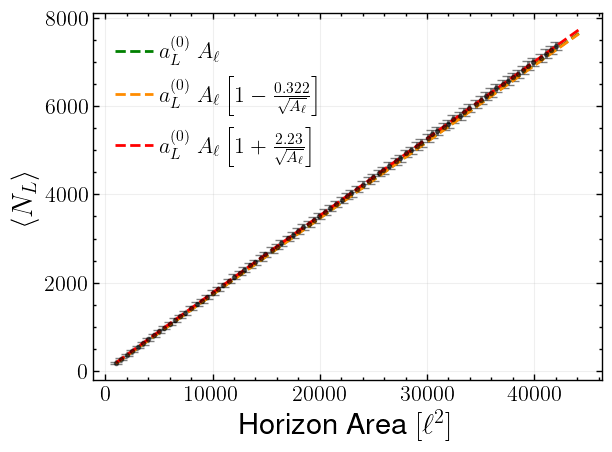

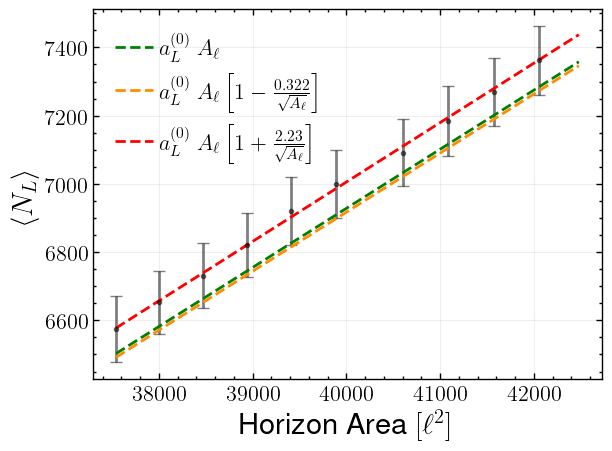

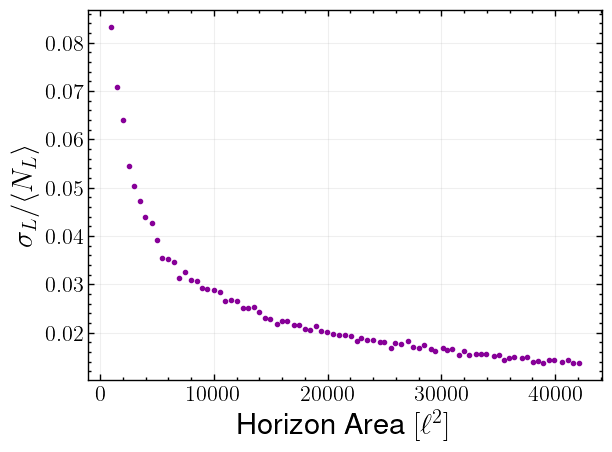

In [13]:
### DO THE NUMERICAL ANALYSIS
##########################################################################
noninf_indices = tuple([np.where(np.isfinite(gradients_unc))[0]])
gradients      = np.array(gradients)[noninf_indices]
gradients_unc  = np.array(gradients_unc)[noninf_indices]


### Find Link proportionality (Barton et al)
##########################################################################
print(" \n#### LINKS ANALYSIS (for Barton et al a = 0.17321) ####")
# Link Counting from weighted sum of gradients (to compare to Barton et al.)
coefsum = sum([(n+1)*gradients[n] for n in range(len(gradients))])
coefsum_unc = np.sqrt(
    sum([((n+1)*gradients_unc[n])**2 for n in range(len(gradients))]))
print(f"Gradients Weighted Sum = {round(coefsum,4)} +- {round(coefsum_unc,4)}")

# Find total number of links for each x
links      = np.zeros(len(molecules_distr[0]))
links_std2 = np.zeros(len(molecules_distr[0]))
for n in range(len(molecules_distr)):
    links      += (n+1)    *np.array(molecules_distr[n])
    links_std2 += (n+1)**2 * np.array(molecules_distr_std[n])**2
links_std = np.sqrt(links_std2)

#########################à
# Fit to linear fit
popt, pcov = curve_fit(lin_func, x, links, sigma=links_std,
                        absolute_sigma=True)
unc = np.sqrt(np.diag(pcov))
print(f"Gradient of Links      = {round(popt[0],4)} +- {round(unc[0],4)}")

################################
# Fit to corrected linear fit
def schwarz_lin_func(x, a):
    return corrected_lin_func(x, a, coeff = -0.0557704)
popt, pcov = curve_fit(schwarz_lin_func, x, links, sigma=links_std,
                        absolute_sigma=True)
unc = np.sqrt(np.diag(pcov))
print(f"Curv-Correct Gradient with a1= -0.0558 = {round(popt[0],4)} +- {round(unc[0],4)}")

r, pvalue = pearsonr(x, links)
print(f"Linearity links: Pearson r = {round(r,3)}, p-val = {round(1-pvalue,3)}")
plus_or_minus = " + " if popt[0]>0 else " "


#######################################
# Fit all
def schwarz_lin_func3(x, a0, a1):
    return corrected_lin_func(x, a0, a1)
popt, pcov = curve_fit(schwarz_lin_func3, x, links, sigma=links_std,
                        absolute_sigma=True)
unc = np.sqrt(np.diag(pcov))
print(f"Ideal a_0_L = {round(popt[0],4)} +- {round(unc[0],4)}")
print(f"Ideal a1= {round(popt[1],4)} +- {round(unc[1],4)}")
print("\n")

#######################################
# Fit correction with fixed flat coeff linear fit
def schwarz_lin_func2(x, a):
    return corrected_lin_func(x, np.sqrt(3)/10, a)
popt, pcov = curve_fit(schwarz_lin_func2, x, links, sigma=links_std,
                        absolute_sigma=True)
unc = np.sqrt(np.diag(pcov))
print(f"Ideal a1 for a^(0)_L=sqrt(3)/10 = {round(popt[0],4)} +- {round(unc[0],4)}")
print("\n")
ideal_corr = round(popt[0]*10/np.sqrt(3),3)
ideal_corr_err = round(unc[0]*10/np.sqrt(3),3)
print(f"Ideal correction as a*l/sqrt(A) == {ideal_corr} +- {ideal_corr_err}")

#####################################################################à
# Do plot for links
plt.figure("Links")
plt.errorbar(x, links, yerr=links_std, capsize=4,fmt=".",ls="", c="black", alpha=0.5)
plt.plot(np.linspace(x[0], x[-1]*1.05, 100), 
            np.linspace(x[0], x[-1]*1.05, 100)*np.sqrt(3)/10, 
            ls = "--", color = "green",
            label = r"$a^{(0)}_{L} \; A_{\ell}$")
plt.plot(np.linspace(x[0], x[-1]*1.05, 100), 
            schwarz_lin_func(np.linspace(x[0], x[-1]*1.05, 100), np.sqrt(3)/10), 
            ls = "--", color = "darkorange",
            label = r"$a^{(0)}_{L} \; A_{\ell} \left[ 1 - \frac{0.322}{\sqrt{A_{\ell}}} \right]$")
plt.plot(np.linspace(x[0], x[-1]*1.05, 100), 
            schwarz_lin_func2(np.linspace(x[0], x[-1]*1.05, 100), popt[0]), 
            ls = "--", color = "red",
            label = r"$a^{(0)}_{L} \; A_{\ell} \left[ 1"
            + f"{plus_or_minus}"+r"\frac{%.2f}{\sqrt{A_{\ell}}} \right]$" %ideal_corr)
plt.xlabel(r'Horizon Area $[\ell^2]$') 
plt.ylabel(r"$\langle N_L \rangle $")
plt.legend(loc="upper left")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(plotsDir + "Links_vs_Area_withFits.png")
plt.savefig(plotsDir + "Links_vs_Area_withFits.pdf")

plt.figure("Links Detail")
plt.errorbar(x[-10:], links[-10:], yerr=links_std[-10:], capsize=4,fmt=".",ls="", c="black", alpha=0.5)
plt.plot(np.linspace(x[-10], x[-1]*1.01, 100), 
            np.linspace(x[-10], x[-1]*1.01, 100)*np.sqrt(3)/10, 
            ls = "--", color = "green",
            label = r"$a^{(0)}_{L} \; A_{\ell}$")
plt.plot(np.linspace(x[-10], x[-1]*1.01, 100), 
            schwarz_lin_func(np.linspace(x[-10], x[-1]*1.01, 100), np.sqrt(3)/10), 
            ls = "--", color = "darkorange",
            label = r"$a^{(0)}_{L} \; A_{\ell} \left[ 1 - \frac{0.322}{\sqrt{A_{\ell}}} \right]$")
plt.plot(np.linspace(x[-10], x[-1]*1.01, 100), 
            schwarz_lin_func2(np.linspace(x[-10], x[-1]*1.01, 100), popt[0]), 
            ls = "--", color = "red",
            label = r"$a^{(0)}_{L} \; A_{\ell} \left[ 1"
            + f"{plus_or_minus}"+r"\frac{%.2f}{\sqrt{A_{\ell}}} \right]$" %ideal_corr)
plt.xlabel(r'Horizon Area $[\ell^2]$') 
plt.ylabel(r"$\langle N_L \rangle $")
plt.legend(loc="upper left")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(plotsDir + "Links_vs_Area_withFits_zoom.png")
plt.savefig(plotsDir + "Links_vs_Area_withFits_zoom.pdf")

# Do plot for links uncertainty
plt.figure("Links Unc")
plt.plot(x, links_std/links, ".", ls="")
plt.xlabel(r'Horizon Area $[\ell^2]$') 
plt.ylabel(r"$ \sigma_L / \langle N_L \rangle $")
#plt.legend(loc="upper left")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(plotsDir + "Links_NormUncs_vs_Area.png")
plt.savefig(plotsDir + "Links_NormUncs_vs_Area.pdf")


# fig = plt.figure("Links with uncs/numb")
# ax = plt.axes()
# axtwin = ax.twinx() #twin axeis sharing x-axis
# ax.set_xlabel(r'Horizon Area $[\ell^2]$') 
# ax.errorbar(x, links, yerr=links_std,
#                 capsize=4,fmt=".",ls="", color = "black")
# ax.plot(np.linspace(x[0], x[-1]*1.05, 100), 
#             np.linspace(x[0], x[-1]*1.05, 100)*np.sqrt(3)/10, 
#             ls = "--", color = "forestgreen",
#             label = r"$a^{(0)}_{L} A_{\ell}$")
# ax.plot(np.linspace(x[0], x[-1]*1.05, 100), 
#             schwarz_lin_func(np.linspace(x[0], x[-1]*1.05, 100), np.sqrt(3)/10), 
#             ls = "--", color = "darkorange",#darkorange
#             label = r"$a^{(0)}_{L} A_{\ell} \left[ 1 - \frac{0.322}{\sqrt{A_{\ell}}} \right]$")
# ax.plot(np.linspace(x[0], x[-1]*1.05, 100), 
#             schwarz_lin_func2(np.linspace(x[0], x[-1]*1.05, 100), popt[0]), 
#             ls = "--", color = "red",
#             label = r"$a^{(0)}_{L} \; A_{\ell} \left[ 1"
#             + f"{plus_or_minus}"+r"\frac{%.3f}{\sqrt{A_{\ell}}} \right]$" %ideal_corr)
# print(f"Ideal correction is: {plus_or_minus}{ideal_corr}")
# ax.set_ylabel(r"$\langle N_L \rangle $")
# p = axtwin.plot(x, links_std/links, "x",ls="", color = "midnightblue")#maroon
# axtwin.set_ylabel( r"$ \sigma_{L}/\langle N_{L} \rangle $" )
# axtwin.spines['right'].set_color(p[-1].get_color()) #color yaxis
# axtwin.yaxis.label.set_color(p[-1].get_color())    #color yaxis label
# axtwin.tick_params(axis='y', colors=p[-1].get_color()) #color yaxis tciks
# #ax.legend(ncol = 2, loc = "upper center", fontsize = 16)
# ax.legend(bbox_to_anchor=(0.12, 0.99), loc='upper left', borderaxespad=0,fontsize=19)
# #ax.legend(loc="upper left")
# #ax.set_zorder(-1)
# plt.tight_layout()
# fig.savefig(plotsDir + "Links_and_NormUncs_vs_Area.png")
# fig.savefig(plotsDir + "Links_and_NormUncs_vs_Area.pdf")    

### Links Fit per Max A

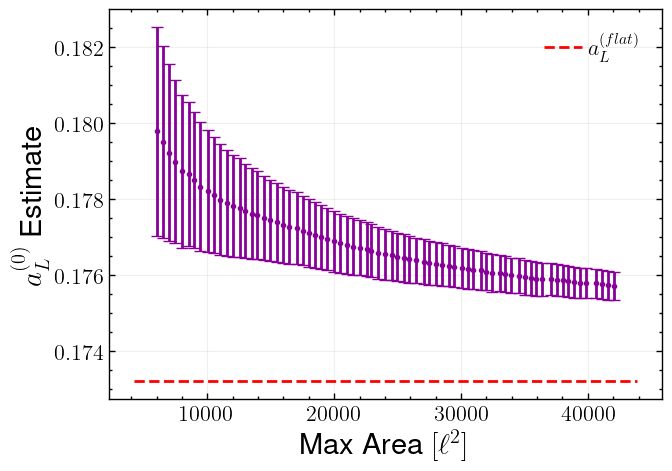

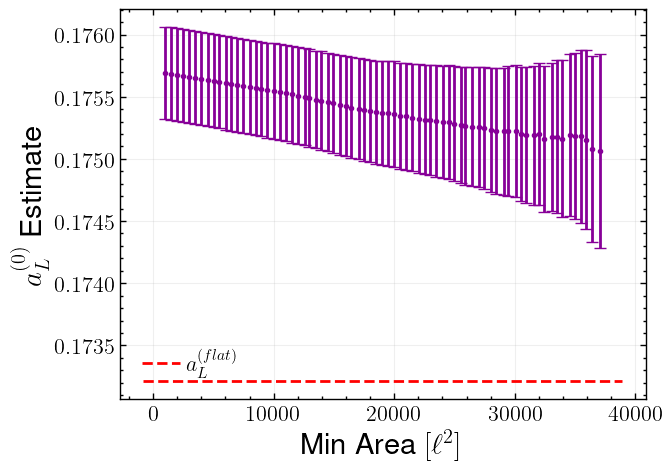

In [14]:
N0 = 10
ests = []
ests_err = []
for N in range(N0, len(molecules_distr[0])): 
    # Find total number of links for each x
    links      = np.zeros(N)
    links_std2 = np.zeros(N)
    for n in range(len(molecules_distr)):
        links      += (n+1)    *np.array(molecules_distr[n][:N])
        links_std2 += (n+1)**2 * np.array(molecules_distr_std[n][:N])**2
    links_std = np.sqrt(links_std2)

    # Fit to linear fit
    popt, pcov = curve_fit(lin_func, x[:N], links, sigma=links_std,
                            absolute_sigma=True)
    unc = np.sqrt(np.diag(pcov))

    ests.append(popt[0])
    ests_err.append(unc[0])

plt.figure("Links Fit per A_max", figsize=(7,5))
plt.errorbar( x[N0:], ests, ests_err, capsize=4,fmt=".",ls="")
plt.xlabel(r'Max Area $[\ell^2]$') 
plt.ylabel(r"$ a^{(0)}_L $ Estimate")
plt.hlines(0.17321, *plt.xlim(), ls="--", color="red", label = r"$ a_L^{(flat)}$")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

N0 = 10
ests = []
ests_err = []
for N in range(N0, len(molecules_distr[0])): 
    # Find total number of links for each x
    links      = np.zeros(N)
    links_std2 = np.zeros(N)
    for n in range(len(molecules_distr)):
        links      += (n+1)    *np.array(molecules_distr[n][-N:])
        links_std2 += (n+1)**2 * np.array(molecules_distr_std[n][-N:])**2
    links_std = np.sqrt(links_std2)

    # Fit to linear fit
    popt, pcov = curve_fit(lin_func, x[-N:], links, sigma=links_std,
                            absolute_sigma=True)
    unc = np.sqrt(np.diag(pcov))

    ests.append(popt[0])
    ests_err.append(unc[0])

plt.figure("Links Fit per A_max", figsize=(7,5))
plt.errorbar( x[:-N0][::-1], ests, ests_err, capsize=4,fmt=".",ls="")
plt.xlabel(r'Min Area $[\ell^2]$') 
plt.ylabel(r"$ a^{(0)}_L $ Estimate")
plt.hlines(0.17321, *plt.xlim(), ls="--", color="red", label = r"$ a_L^{(flat)}$")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


## Distribution & Entropy

p_n list and sigma_p_n obtained with gradients
[0.78411, 0.16747, 0.03792, 0.00833, 0.00174, 0.00034, 6e-05, 1e-05, 0.0, 0.0, 0.0]
[0.00214, 0.00086, 0.0004, 0.00018, 8e-05, 4e-05, 2e-05, 1e-05, 0.0, 1e-05, 1e-05]
p_n list and sigma_p_n obtained with overall occurrences
[0.78412, 0.16746, 0.03791, 0.00834, 0.00175, 0.00034, 7e-05, 1e-05, 0.0, 0.0, 0.0]
[0.0008, 0.00072, 0.00039, 0.00018, 8e-05, 4e-05, 2e-05, 1e-05, 0.0, 0.0, 0.0]
Just noting that lamb_occurs was used, rather than grad_sum for        
the probabilities p_n
 
#### N-LAMBDAS DISTRIBUTION ####
Distribution of n-lambdas:
 [0.7841155, 0.167461, 0.0379134, 0.0083379, 0.0017469, 0.0003438, 6.68e-05, 1.19e-05, 2.4e-06, 3e-07, 1e-07]
Ratio of n+1_to_n-lambdas:
 [0.21357, 0.2264, 0.21992, 0.20951, 0.19681, 0.19437, 0.17788, 0.20226, 0.12089, 0.24029]
Ratio of n_to_n+1-lambdas:
 [4.68238, 4.41693, 4.54714, 4.77301, 5.08094, 5.14476, 5.62166, 4.94406, 8.27186, 4.16161]

I - FIT RESULTS
Exponential fit (1-I) I^(n-1) has:
 - I = 0.21

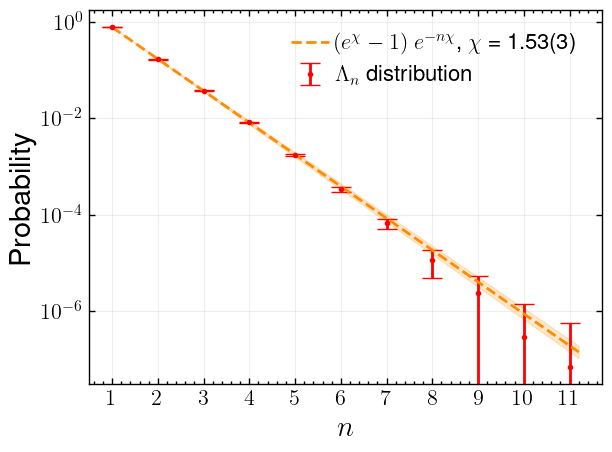

 
#### FINAL RESULTS ####
Overall Proportion C_hv = 0.09195 +- 0.00031
Discreteness scale      = 0.60647 +- 0.00102 l_p



In [15]:
##########################################################################
### Find Probability Distribution of Lambda
##########################################################################
# Get Probs from Gradient
grad_sum = sum(gradients)
grad_sum_unc = np.sqrt(sum([g**2 for g in gradients_unc]))
lambd_probs = gradients/sum(gradients)
lambd_probs_uncs = np.sqrt(gradients_unc**2/grad_sum**2 +
                        gradients**2*grad_sum_unc**2/grad_sum**4)
print("p_n list and sigma_p_n obtained with gradients")
print([round(pn,5) for pn in lambd_probs])
print([round(spn,5) for spn in lambd_probs_uncs])

# Get Probs from Counts directly - more weight on larger M
# lambd_occurs[n] is the number of mols found in total of size n
lambd_occurs = np.array([sum(molecules_distr[n]) 
                for n in range(len(molecules_distr))])
lambd_occurs_stds = np.sqrt([sum(np.array(molecules_distr_std[n])**2)
                        for n in range(len(molecules_distr))])
S = sum(lambd_occurs)*1.
lambd_probs = lambd_occurs/S
lambd_probs_uncs = np.sqrt(((S - lambd_occurs)/S**2)**2 * lambd_occurs_stds**2 \
                        +\
                        lambd_occurs**2/S**4 * sum(lambd_occurs_stds**2)\
                        - lambd_occurs**2/S**4 * lambd_occurs_stds**2)
print("p_n list and sigma_p_n obtained with overall occurrences")
print([round(pn,5) for pn in lambd_probs])
print([round(spn,5) for spn in lambd_probs_uncs])
print("Just noting that lamb_occurs was used, rather than grad_sum for\
        \nthe probabilities p_n")


###################################################################
# Fit Probability to exponential (1-I) * I**n

unsafe_start = len(noninf_indices[0]) #gets rid of data with bad statistics
ns = np.arange(1, unsafe_start+1)
popt, pcov = curve_fit(i_exp, ns, lambd_probs[:unsafe_start], 
                        p0 = 1-lambd_probs[0],
                        sigma=lambd_probs_uncs[:unsafe_start],
                        absolute_sigma=True)
unc = np.sqrt(np.diag(pcov)) 
#expected = i_exp(ns, *popt)
#Chi2, pvalue = chisquare(lambd_occurs[:unsafe_start], expected, len(popt))
print(" \n#### N-LAMBDAS DISTRIBUTION ####")
print("Distribution of n-lambdas:\n",
        [round(pn,7) for pn in lambd_probs])
print("Ratio of n+1_to_n-lambdas:\n",
        [round(lambd_probs[n+1]/lambd_probs[n],5) 
        for n in range(len(lambd_probs)-1)])
print("Ratio of n_to_n+1-lambdas:\n",
        [round(lambd_probs[n]/lambd_probs[n+1],5) 
        for n in range(len(lambd_probs)-1)])
print("\nI - FIT RESULTS")
print("Exponential fit (1-I) I^(n-1) has:")
print(f" - I = {round(popt[0],4)} +- {round(unc[0],4)}")
print(f"With e^-x rather than I, it has:")
print(f" - x = {-round(np.log(popt[0]),4)} +- {round(unc[0]/popt[0],4)}")
#print(f"The associated Chi2 = {Chi2} and p-value = {pvalue}")

###################################################################
# Do numerical calculation rather than fit for exponential 
r1 = grad_sum/coefsum
r1unc = grad_sum_unc/coefsum
I = 1 - r1
Iunc = r1unc
chi = - np.log(I)
chiunc = Iunc/I
chi_ord = 0
chiunc_copy = chiunc*1.
while abs(chiunc_copy) < 1:
        chiunc_copy *= 10
        chi_ord += 1
chi_ord -= 1
print("\nPLAIN NUMERICAL RESULTS")
print(f"Exponential model (1-I) I^(n-1) has:")
print(f" - I = {round(I,4)} +- {round(Iunc,4)}")
print(f"With e^-x rather than I, it has:")
print(f" - x = {round(chi,4)} +- {round(chiunc,4)}")
print(f"p1 = {round(lambd_probs[0],4)} == gradsum/a_links = {round(r1,4)}?")


xmax = min(11, len(lambd_probs))
plt.figure("n-lambda exp probability distribution (logscale) with unc")
plt.errorbar(np.arange(1,xmax+1,1), lambd_probs[:xmax],
        yerr=lambd_probs_uncs[:xmax],
        capsize=7,fmt=".",ls="",color="red",
        label = r"$\Lambda_n$ distribution"
        )
xs = np.linspace(1, xmax+0.2,100)
plt.fill_between(xs, chi_exp(xs, 1.49), chi_exp(xs, 1.55), 
                color = "darkorange", alpha = 0.2
                )
plt.plot(xs, chi_exp(xs, 1.52), ls = "--", color = "darkorange",
        label = r"$(e^{\chi}-1)$ $e^{- n \chi}$, $\chi$"+ 
        f" = {round(chi,chi_ord)}"+
        f"({int(round(0.03,chi_ord)*10**chi_ord)})"
        #f"({int(round(chiunc,chi_ord)*10**chi_ord)})"
        )
plt.xlabel(r"$n$")
plt.ylabel("Probability")
plt.yscale("log")
plt.legend(loc="upper right")
plt.grid(alpha=0.2)
plt.xticks(np.arange(1,xmax+1,1))
plt.tight_layout()
plt.savefig(plotsDir + "n_lambda_prob_distribution_expx_logy_withcloud.png")
plt.savefig(plotsDir + "n_lambda_prob_distribution_expx_logy_withcloud.pdf")
plt.show()

##########################################################################
### Find Entropy and C_hv and Discretness Length Scale
##########################################################################
print(" \n#### FINAL RESULTS ####")
# Find overall proportionality and discreteness scale
C_hv = sum(gradients*np.log(grad_sum/gradients))
dC_da_i = np.log(grad_sum/gradients)
C_hv_unc = np.sqrt( sum(gradients_unc**2 * dC_da_i**2))  
print(f"Overall Proportion C_hv = {round(C_hv,5)} +- {round(C_hv_unc,5)}")

# Discreteness length in terms of Planckian length
l = 2*np.sqrt(C_hv)
l_unc = C_hv_unc/np.sqrt(C_hv)
print(f"Discreteness scale      = {round(l,5)} +- {round(l_unc,5)} l_p\n")